In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import RFECV

from data_preporation import prepare, get_cabin_id
from data_preporation import get_family_id
from data_preporation import get_ticket_prefix_id
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from utils import plot_learning_curve
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

In [3]:
# Print you can execute arbitrary python code
train = pd.read_csv("data/train.csv", dtype={"Age": np.float64}, )
test = pd.read_csv("data/test.csv", dtype={"Age": np.float64}, )
# Family distribution
family_id_mapping = {}
train.apply(lambda row: get_family_id(row, family_id_mapping), axis=1)
test.apply(lambda row: get_family_id(row, family_id_mapping), axis=1);
# Ticket distribution
get_ticket_prefix_id_mapping = {}
train.apply(lambda row: get_ticket_prefix_id(row, get_ticket_prefix_id_mapping), axis=1)
test.apply(lambda row: get_ticket_prefix_id(row, get_ticket_prefix_id_mapping), axis=1);
# cabin distribution
cabin_id_mapping = {}
train.apply(lambda row: get_cabin_id(row, cabin_id_mapping), axis=1)
test.apply(lambda row: get_cabin_id(row, cabin_id_mapping), axis=1);

In [4]:
prepare(train, family_id_mapping, get_ticket_prefix_id_mapping, cabin_id_mapping);

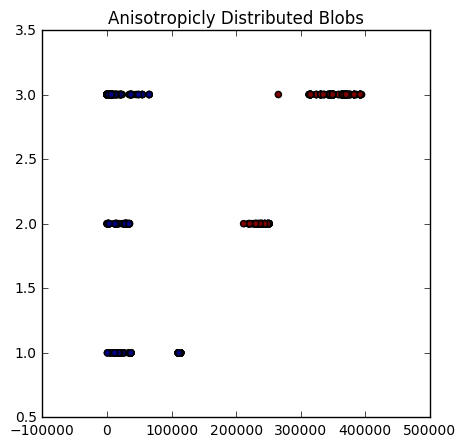

In [5]:
random_state = 170
KMF = ['Ticket_s', 'Pclass', 'CabinN']
kmx = train[KMF]

km_model = KMeans(n_clusters=2, random_state=random_state).fit(kmx)
#print(km_model.score(kmx))
y_pred = km_model.predict(kmx)

plt.figure(figsize=(5, 5))
plt.scatter(train[['Ticket_s']], train[['Pclass']], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")
plt.show()
    

train['Ticket_s_g'] = y_pred;

In [6]:
predictors = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'SibSp', 'Parch', 'FamilySize', 'NameLength', 'Title', 'FamilyId', 'CabinN']

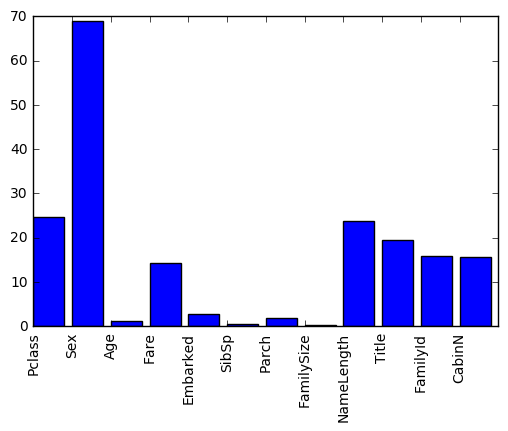

In [7]:
# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(train[predictors], train["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

Confusion matrix, without normalization
[[477  72]
 [ 88 254]]


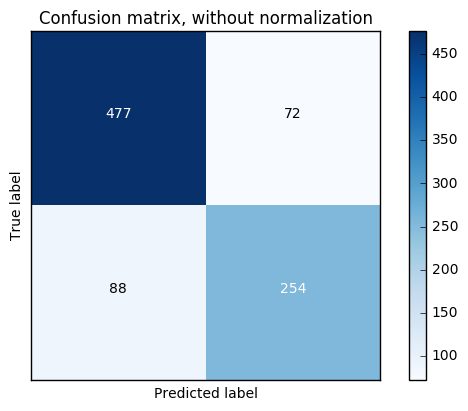

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.neural_network import MLPClassifier

polynomial_features = PolynomialFeatures(degree=1, include_bias=False)
alg = linear_model.LogisticRegression()
#alg = AdaBoostClassifier()
#alg = RandomForestClassifier(n_estimators=300)
#alg = SVC()
#alg = MLPClassifier(hidden_layer_sizes=(24,24,24))


pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("logistic_regression", alg)])
scores = cross_val_score(
    pipeline,
    train[predictors],
    train["Survived"],
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=50)
)
print(scores)
print(scores.mean())

Confusion matrix, without normalization
[[477  72]
 [ 88 254]]


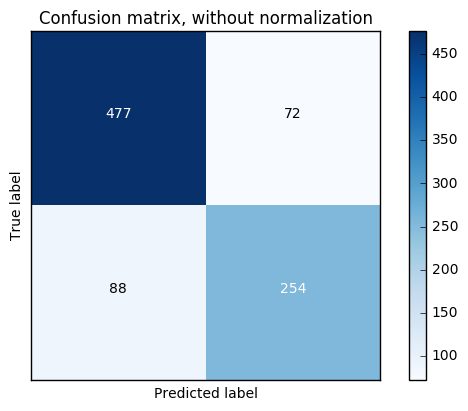

In [15]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
# Train the algorithm using all the training data

alg.fit(train[predictors], train["Survived"])
cnf_matrix = confusion_matrix(train["Survived"], alg.predict(train[predictors]))
plot_confusion_matrix(cnf_matrix, classes=[], title='Confusion matrix, without normalization')
plt.show()

Plot train scores [ 0.88135593  0.84455959  0.8190184   0.82318841  0.81986532]
Plot test scores [ 0.74523008  0.79685746  0.79685746  0.80920314  0.81593715]


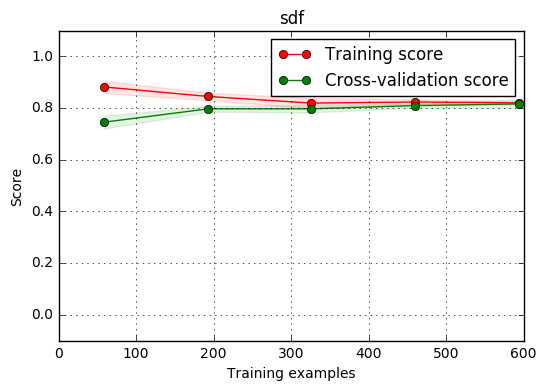

In [64]:
plot_learning_curve(pipeline, "sdf", train[predictors], train["Survived"], (-0.1, 1.1), cv=3, n_jobs=1)
plt.show()

In [26]:
#Optimal number of features and visualize this
if False:
    rfecv_X = train[predictors]
    rfecv_Y = train["Survived"]
    rfecv = RFECV( estimator = alg , step = 1 , cv = StratifiedKFold( rfecv_Y , 2 ) , scoring = 'accuracy' )
    rfecv.fit( rfecv_X , rfecv_Y )
    plt.figure()
    plt.xlabel( "Number of features selected" )
    plt.ylabel( "Cross validation score (nb of correct classifications)" )
    plt.plot( range( 1 , len( rfecv.grid_scores_ ) + 1 ) , rfecv.grid_scores_ )
    plt.show()

In [27]:
#TEST
prepare(test, family_id_mapping, get_ticket_prefix_id_mapping, cabin_id_mapping)
test['Ticket_s_g'] = km_model.predict(test[KMF])

D:\dev\kits\python\lib\site-packages\pandas\core\ops.py:716: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [51]:
# Make predictions using the test set.
predictions = alg.predict(test[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": predictions
})
submission.to_csv("data/kaggle.csv", index=False)